In [5]:
CLOUD = True

import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

PATH = Path('C:/StudioProjects/Hemorrhage')
PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla_py.data_parallel as dp
    import torch_xla_py.utils as xu
    import torch_xla_py.xla_model as xm


#sys.path.insert(0, "C:\\fastai")
from fastai import *
from fastai.vision import *
from fastai.tabular import *
from fastprogress import *

VERSION = 2

In [6]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"; conda activate pytorch-nightly; jupyter notebook

# 35.204.242.164

In [3]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))

In [4]:
filename = PATH_WORK/'yuvals_indexes_file.pkl'
all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

In [5]:
trn_data = train_md.loc[train_md.img_id.isin(all_idx[train_ids])]
val_data = train_md.loc[train_md.img_id.isin(all_idx[val_ids])]

In [6]:
assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
    == len(train_md.SeriesInstanceUID.unique())

In [7]:
assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
    >= len(train_md.PatientID.unique())

In [8]:
ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
ids_df = ids_df.join(train_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

assert len(ids_df.SeriesInstanceUID.unique()) == 19530

In [9]:
test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

In [10]:
filename = PATH_WORK/'yuvals_test_indexes.pkl'
test_ids = pickle.load(open(filename,'rb'))

In [11]:
test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
test_ids_df = test_ids_df.join(test_md[['img_id','SeriesInstanceUID','pos_idx']].set_index('img_id'), on = 'img_id')

assert len(test_ids_df.SeriesInstanceUID.unique()) == 2214

In [12]:
pd.concat([test_md[cols_cat + cols_float].mean(0),
           trn_data[cols_cat + cols_float].mean(0),
           val_data[cols_cat + cols_float].mean(0)],axis=1)

,0,1,2
BitsStored,0.040435,0.493129,0.494393
PixelRepresentation,0.039672,0.489732,0.491567
RescaleIntercept,0.001884,0.025994,0.023441
WindowCenter_1_NAN,0.040435,0.493129,0.494393
ImageOrientationPatient_0,0.999491,0.999703,0.999969
ImageOrientationPatient_1,-0.000509,0.000072,0.000118
ImageOrientationPatient_2,0.000000,0.000015,-0.000118
ImageOrientationPatient_3,0.000495,-0.000066,-0.000132
ImageOrientationPatient_4,0.948793,0.973095,0.972877
ImageOrientationPatient_5,-0.285991,-0.154848,-0.156091


In [13]:
meta_cols = ['pos_size','pos_idx','pos_inc','pos_rel','pos_zeros']

In [14]:
meta_cols = cols_cat + cols_float

# Pre-processing

In [2]:
if False:
    filename = PATH_WORK/'yuvals_model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


    filename = PATH_WORK/'yuvals_model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
    feats = pickle.load(open(filename,'rb'))

    for series_id in tqdm(test_ids_df.SeriesInstanceUID.unique()):
        mask = torch.BoolTensor(test_ids_df.SeriesInstanceUID.values == series_id)
        feats_id = feats[mask]
        pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Model

In [90]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [18]:
all_black = '006d4432e'

path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
black_feats = pickle.load(open(path,'rb'))[41]

In [67]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, ids_df, mode='train'):
        
        super(RSNA_DataSet, self).__init__()
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.series = metadata.SeriesInstanceUID.unique()
        self.metadata = metadata
        self.ids_df = ids_df
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        
        folder = 'test' if self.mode == 'test' else 'train'
        path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
        feats = pickle.load(open(path,'rb'))
        ids_df_sub = self.ids_df.loc[self.ids_df.SeriesInstanceUID.values == series_id]
        
        if feats.shape[0] > len(df):
            mask_dup = ~ids_df_sub.img_id.duplicated().values
            ids_df_sub = ids_df_sub.loc[mask_dup]
            feats = feats[torch.BoolTensor(mask_dup)]
        
        assert feats.shape[0] == len(df)
        assert len(ids_df_sub) == len(df)
        assert np.all(ids_df_sub.img_id.isin(df.img_id).values)
        order = np.argsort(ids_df_sub.pos_idx.values)
        assert np.all(ids_df_sub.img_id.values[order] == df.img_id.values)
        feats = feats[torch.LongTensor(order)]
        
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        offset = np.random.randint(0, 61 - feats.shape[0])
        if offset > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(offset,1), feats], dim=0)
        if (60 - len(df) - offset) > 0:
            dummy_row = torch.cat([black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(60 - len(df) - offset,1)], dim=0)
        assert feats.shape[0] == 60
        
        target = torch.cat([torch.Tensor(df[all_ich].values), 
                            torch.zeros((60 - len(df), len(all_ich)))], dim=0)
        feats = feats.transpose(1,0)
        
        return feats, target
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [54]:
class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class BCEWithLogitsLoss(_Loss):
    __constants__ = ['weight', 'pos_weight', 'reduction']

    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None):
        super(BCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
    
    def forward(self, input, target):
        #((torch.log(1+torch.exp(input)) - target*input)*self.weight).mean()
        return F.binary_cross_entropy_with_logits(input.squeeze(), target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [55]:
class FeatProduct(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(FeatProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(out_feature, in_feature))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        output = F.linear(x, self.weight)
        return output

In [56]:
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., use_bn:bool=True, bn_final:bool=False, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.n_cont = n_cont
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.feat_product = FeatProduct(feat_sz + n_cont, 20)
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)

    def get_sizes(self, layers, out_sz):
        return [1200] + layers + [out_sz]

    def forward(self, x) -> Tensor:
        x = self.bn_cont(x)
        x = x.transpose(1,2)
        x = self.fc_drop(x)
        x = self.feat_product(x)
        x = self.relu(x)
        x = x.reshape(x.shape[0],-1)
        x = self.layers(x)
        x = x.reshape(x.shape[0],60,6)
        return x

In [57]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

In [58]:
def disable_progress():
    fastprogress.NO_BAR = True
    master_bar, progress_bar = force_console_behavior()
    basic_train.master_bar, basic_train.progress_bar = master_bar, progress_bar
    
def enable_progress():
    basic_train.master_bar, basic_train.progress_bar = master_bar, progress_bar

# Running

In [ ]:
# mixup
# position randomization
# one-cycle
# fill empty with all black features, and meta of the last

In [14]:
VERSION = 2

In [43]:
def train_one(weight=None, load_model=True, epochs=1, bs=100):
    
    cur_epoch = getCurrentBatch()
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    #sampler = None
    #if False:
    #    ww = torch.DoubleTensor(wt)
    #    sampler = torch.utils.data.sampler.WeightedRandomSampler(ww, len(ww), replacement=True)
    
    trn_ds = RSNA_DataSet(trn_data, ids_df, mode='train')
    val_ds = RSNA_DataSet(val_data, ids_df, mode='valid')
    tst_ds = RSNA_DataSet(test_md, test_ids_df, mode='test')
    df = DataBunch.create(train_ds=trn_ds, valid_ds=val_ds, test_ds=tst_ds, bs=bs, num_workers=0)
    
    tab_model = TabularModel(n_cont = len(meta_cols), out_sz=360, \
                             layers=[500,200], ps=[0.5,0.5], bn_final=True)
    loss_func = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).cuda())
    model = Learner(df, tab_model, path=PATH_WORK, loss_func=loss_func)#.mixup()
    
    model_file_name = modelFileName(return_last=True)
    if load_model:
        if model_file_name is not None:
            print('loading model', model_file_name)
            model.load(PATH_WORK/'models'/model_file_name)
        else:
            print('starting from scratch')
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        model.fit(1, 1e-1, wd=5e-3)
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True)
        if not DATA_SMALL:
            model.save(PATH_WORK/'models'/model_file_name)

        st = time.time()
        disable_progress()
        predictions = np.array(model.get_preds(ds_type=DatasetType.Valid)[0])
        enable_progress()
        
        loc_data = val_data.copy()
        if DATA_SMALL:
            val_sz = int(0.01*len(val_data.SeriesInstanceUID.unique()))
            val_series = val_data.SeriesInstanceUID.unique()[:val_sz]
            loc_data = loc_data.loc[val_data.SeriesInstanceUID.isin(val_series)]

        val_results = np.zeros((len(loc_data),6))
        for k, series in enumerate(loc_data.SeriesInstanceUID.unique()):
            mask = loc_data.SeriesInstanceUID == series
            val_results[mask] = predictions[k,:mask.sum()]

        #ll = log_loss(loc_data.loc[:,all_ich].reshape(-1), val_results.reshape(-1), eps=1e-6)
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]

        print('epoch {}, val ll: {:.4f}, cor: {:.4f}'.format(i, ll, cor))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time]], 
                                   columns = 
                                    ['epoch','fold','loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(0,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        if not DATA_SMALL:
            epoch_stats.to_csv(stats_filename, index=False)
    
    return model

In [147]:
DATA_SMALL = False
model = train_one()

completed epochs: 3 starting now: 1
loading model model.b3.f0.v2


epoch,train_loss,valid_loss,time
0,0.051856,0.057619,55:30


Val epoch 4, ll 0.1001, cor 0.7310


In [68]:
DATA_SMALL = True
model = train_one()

completed epochs: 4 starting now: 1
loading model model.b4.f0.v2


epoch,train_loss,valid_loss,time
0,0.127215,147.537949,00:24


epoch 5, val ll: 1.4110, cor: -0.0124


In [148]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time
0,4,0,0.10014,0.731025,0.164123,0.016662,0.097562,0.048806,0.094238,0.115467,17577,1953,100,3330.288549,208.896577


In [138]:
val_sz = len(val_data.SeriesInstanceUID.unique())
if DATA_SMALL: val_sz = int(0.01*val_sz)
val_series = val_data.SeriesInstanceUID.unique()[:val_sz]
val_target = np.zeros((val_sz,60,6))
for i, series in enumerate(val_series):
    mask = val_data.SeriesInstanceUID == series
    val_target[i,:mask.sum()] = val_data.loc[mask, all_ich]

print('Log-loss', log_loss(val_target.reshape(-1),predictions.reshape(-1),eps=1e-6))
print('correlation', np.corrcoef(val_target.reshape(-1),predictions.reshape(-1))[0,1])

Log-loss 0.0462624751187673
correlation 0.7656300002685762


In [139]:
predictions.mean((0,1))

array([0.059284, 0.003352, 0.018136, 0.016913, 0.017706, 0.028348], dtype=float32)

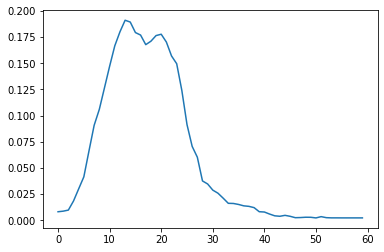

In [152]:
plt.plot(predictions.mean(0)[:,0])

In [140]:
val_target.mean((0,1))

array([0.077718, 0.001647, 0.026267, 0.019449, 0.024364, 0.033658])

# Inference

In [69]:
DATA_SMALL = False
predictions = np.array(model.get_preds(ds_type=DatasetType.Test)[0])

In [70]:
predictions.mean((0,1))

array([0.087846, 0.004184, 0.029325, 0.030316, 0.041098, 0.029221], dtype=float32)

In [71]:
sub = pd.DataFrame()
for i, series_id in enumerate(test_md.SeriesInstanceUID.unique()):
    df = test_md.loc[test_md.SeriesInstanceUID == series_id]
    id_column = [a + '_' + b for a in df.SOPInstanceUID for b in all_ich]
    data_sub = pd.DataFrame({'ID':np.array(id_column), 'Label':predictions[i,:len(df)].reshape(-1)})
    sub = pd.concat([sub,data_sub], axis=0, sort=False)

sub = sub.reset_index(drop=True)

In [72]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1471214

In [57]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1255341744607709

In [73]:
sub.to_csv(PATH/'submission.csv', index=False)

In [59]:
best_sub = pd.read_csv(PATH/'submission20.csv')

In [74]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9499705853123557